In [1]:
import numpy as np
import os
import cv2
from sklearn.model_selection import train_test_split

def get_files(dir_path):
    return [f for f in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, f))]

dataset_samples = []
dataset_labels = []

def read_dataset_dir(dir_path, label, dataset_samples, dataset_labels):
    for filename in get_files(dir_path):
        image = cv2.cvtColor(cv2.imread(os.path.join(dir_path, filename)), cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (24, 72))
        dataset_samples.append(image)
        dataset_labels.append(label)

red_samples, red_labels = [], []
read_dataset_dir('dataset/simulator/red', 0, red_samples, red_labels)
read_dataset_dir('dataset/udacity-sdc/red', 0, red_samples, red_labels)

yellow_samples, yellow_labels = [], []
read_dataset_dir('dataset/simulator/yellow', 1, yellow_samples, yellow_labels)
read_dataset_dir('dataset/udacity-sdc/yellow', 1, yellow_samples, yellow_labels)

green_samples, green_labels = [], []
read_dataset_dir('dataset/udacity-sdc/green', 2, green_samples, green_labels)
read_dataset_dir('dataset/simulator/green', 2, green_samples, green_labels)

red_samples = np.array(red_samples)
red_labels = np.array(red_labels)

X_red_train, X_red_test, y_red_train, y_red_test = train_test_split(
    red_samples,
    red_labels,
    test_size=0.05,
    random_state=42
)

X_yellow_train, X_yellow_test, y_yellow_train, y_yellow_test = train_test_split(
    yellow_samples,
    yellow_labels,
    test_size=0.05,
    random_state=42
)

X_green_train, X_green_test, y_green_train, y_green_test = train_test_split(
    green_samples,
    green_labels,
    test_size=0.05,
    random_state=42
)

X_train = np.concatenate([X_red_train, X_yellow_train, X_green_train], axis=0)
y_train = np.concatenate([y_red_train, y_yellow_train, y_green_train], axis=0)

X_test = np.concatenate([X_red_test, X_yellow_test, X_green_test], axis=0)
y_test = np.concatenate([y_red_test, y_yellow_test, y_green_test], axis=0)


In [2]:
### Replace each question mark with the appropriate value.

# Number of training examples
n_train = X_train.shape [0]

# Number of testing examples.
n_test = X_test.shape [0]

# What's the shape of an traffic sign image?
image_shape = X_train.shape [1:3]

# TODO: How many unique classes/labels there are in the dataset.
n_classes = 3

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

train_memory_amount = n_train * (image_shape[0] * image_shape[1] * 3 + n_classes) / 1024 / 1024
test_memory_amount = n_test * (image_shape[0] * image_shape[1] * 3 + n_classes) / 1024 / 1024
all_memory_amount = train_memory_amount + test_memory_amount
print("Train memory amount (Mb) =", train_memory_amount)
print("Test memory amount (Mb) =", test_memory_amount)
print("All memory amount (Mb) =", all_memory_amount)


Number of training examples = 858
Number of testing examples = 47
Image data shape = (72, 24)
Number of classes = 3
Train memory amount (Mb) = 4.24427604675293
Test memory amount (Mb) = 0.23249530792236328
All memory amount (Mb) = 4.476771354675293


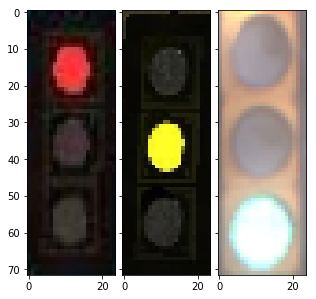

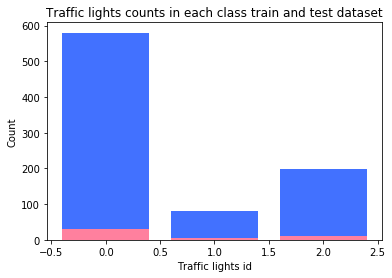

In [3]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

train_classes_sizes = [np.count_nonzero(y_train==i) for i in range (n_classes)] 
test_classes_sizes = [np.count_nonzero(y_test==i) for i in range (n_classes)] 

def show_images_in_grid (images, rows, cols):
    fig = plt.figure (figsize=(5., 10.))
    grid = ImageGrid(fig, 111,
                     nrows_ncols=(rows, cols),
                     axes_pad=0.1
                     )
    for i in range(len (images)):
        grid[i].imshow(images [i])

    plt.show()

#table of traffic sign examples for diffetent classes
im_pos = 0
X_train_examples = []
# num_of_examples = 10
for i in range(n_classes):
    X_train_examples.append (X_train [im_pos])
    im_pos += train_classes_sizes [i]

show_images_in_grid (X_train_examples, 1, n_classes)

#counts of examples in each classes
plt.figure ()
plt_x = range (n_classes)
train_classes_sizes = [np.count_nonzero(y_train==i) for i in range (n_classes)] 
test_classes_sizes = [np.count_nonzero(y_test==i) for i in range (n_classes)] 
plt.bar (plt_x, train_classes_sizes, color=(0.2588,0.4433,1.0))
plt.bar (plt_x, test_classes_sizes, color=(1.0,0.5,0.62))
plt.xlabel ('Traffic lights id')
plt.ylabel ('Count')
plt.title ('Traffic lights counts in each class train and test dataset')
plt.show ()

# Visualizations will be shown in the notebook.
%matplotlib inline

In [4]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.

#rescaling of pixel magnitudes
X_train_preprocessed = np.divide(X_train, 255).astype (np.float32);
X_test_preprocessed = np.divide(X_test, 255).astype (np.float32);

#dividing into train and validation dataset

def shuffle_dataset (dataset_x, dataset_y):
    assert len (dataset_x) == len (dataset_y)
    p = np.random.permutation(len(dataset_x))
    return dataset_x [p], dataset_y [p]

def split_into_train_and_validation_dataset (dataset_x, dataset_y, train_proportion):
    train_samples_by_classes = []
    train_labels_by_classes = []
    X_train_samples = np.zeros ((0, image_shape[0], image_shape[1], 3))
    y_train_samples = np.zeros ((0,))
    X_validation_samples = np.zeros ((0, image_shape[0], image_shape[1], 3))
    y_validation_samples = np.zeros ((0,))
    sample_index = 0
    for class_size in train_classes_sizes:
        train_samples_count = int(train_proportion * class_size)

        #getting and shuffle one class samples
        dataset_x_for_class = dataset_x[sample_index:sample_index + class_size]
        dataset_y_for_class = dataset_y[sample_index:sample_index + class_size]
        dataset_x_for_class, dataset_y_for_class = shuffle_dataset (dataset_x_for_class, dataset_y_for_class)
        
        #splitting to train and validation dataset
        X_train_for_class = dataset_x_for_class[0:train_samples_count]
        y_train_for_class = dataset_y_for_class[0:train_samples_count]
        X_valid_for_class = dataset_x_for_class[train_samples_count:class_size]
        y_valid_for_class = dataset_y_for_class[train_samples_count:class_size]
        
        #storing train samples by classes
        #this will be used later to generate augmented dataset
        train_samples_by_classes.append (X_train_for_class)
        train_labels_by_classes.append (y_train_for_class)
        
        #storing samples in corresponding datasets
        X_train_samples = np.concatenate((X_train_samples, X_train_for_class), axis=0)
        y_train_samples = np.concatenate((y_train_samples, y_train_for_class), axis=0)
        X_validation_samples = np.concatenate((X_validation_samples, X_valid_for_class), axis=0)
        y_validation_samples = np.concatenate((y_validation_samples, y_valid_for_class), axis=0)
        
        sample_index += class_size
        
    return X_train_samples, y_train_samples, X_validation_samples, y_validation_samples, train_samples_by_classes, train_labels_by_classes

X_train_for_learning, \
y_train_for_learning, \
X_valid_for_learning, \
y_valid_for_learning, \
samples_by_classes, \
labels_by_classes = split_into_train_and_validation_dataset (X_train_preprocessed, y_train, 0.8)


In [5]:
### Generate data additional data (OPTIONAL!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.

import random as rand
import cv2    

# generate @generate_count images from given @images
def augment_images (images, generate_count):
    images_last_index = len (images) - 1
    augmented = []
    for i in range (generate_count):
        im1 = images [rand.randint (0, images_last_index)]
        
        #rotation and scaling
        Mrot = cv2.getRotationMatrix2D((16,16),rand.uniform(-5.0, 5.0), rand.uniform(0.95, 1.05))

        #affine transform and shifts
        pts1 = np.float32([[0,0],[image_shape[1],0],[image_shape[1], image_shape[0]]])
        a = 5;
        shift = 8
        shiftx = rand.randint (-shift, shift);
        shifty = rand.randint (-shift, shift);
        pts2 = np.float32([[
                    0 + rand.randint (-a, a) + shiftx,
                    0 + rand.randint (-a, a) + shifty
                ],[
                    image_shape[1] + rand.randint (-a, a) + shiftx,
                    0 + rand.randint (-a, a) + shifty
                ],[
                    image_shape[1] + rand.randint (-a, a) + shiftx,
                    image_shape[0] + rand.randint (-a, a) + shifty
                ]])
        M = cv2.getAffineTransform(pts1,pts2)
        (h, w) = im1.shape[:2]

        augmented_image = cv2.warpAffine(
            cv2.warpAffine (
                im1
                , Mrot, (w, h)
            )
            , M, (w,h)
        )
        
        augmented_image += rand.uniform(-0.2, 0.2)
        np.clip(augmented_image, 0.0, 1.0, out=augmented_image)
        
        augmented.append (augmented_image)
        
    return augmented


In [6]:
#augmented dataset will be stored in this global variables
X_train_augmented = np.zeros ((0, image_shape[0], image_shape[1], 3))
y_train_augmented = np.zeros ((0,))

#generate images up to 3000 images for each class
#augmented dataset will contain only generated images
augment_limit = 3000
def augment_dataset ():
    global X_train_augmented
    global y_train_augmented
    X_train_augmented = np.zeros ((0, image_shape[0], image_shape[1], 3))
    y_train_augmented = np.zeros ((0,))
    
    for augmenting_index in range(n_classes):
        samples = samples_by_classes [augmenting_index]
        labels = labels_by_classes [augmenting_index]

        augment_count = augment_limit
        new_samples = augment_images (samples, augment_count)
        y_train_augmented = np.concatenate((y_train_augmented, [augmenting_index for i in range (augment_count)]), axis=0)

        X_train_augmented = np.concatenate((X_train_augmented, new_samples), axis=0)


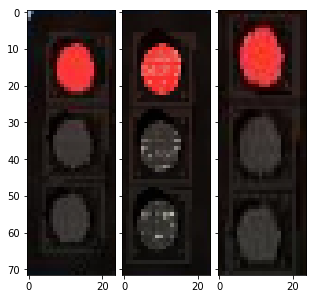

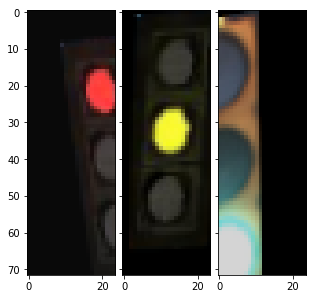

In [7]:
#showing examples of augmented dataset
show_images_in_grid ([X_train_for_learning [i] for i in range(3)], 1, 3)
augment_dataset ()
show_images_in_grid ([X_train_augmented [i] for i in range(0, n_classes * augment_limit, augment_limit)], 1, 3)


In [8]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

import tensorflow as tf
tf.reset_default_graph()

batch_size = 128

import math
# I taken it from my solution to lab quiz
def batches(batch_size, features, labels):
    """
    Create batches of features and labels
    :param batch_size: The batch size
    :param features: List of features
    :param labels: List of labels
    :return: Batches of (Features, Labels)
    """
    assert len(features) == len(labels)
    batches_arr = []
    num_full_batches = math.floor(len(features) / batch_size)
    num_full_batches_samples = num_full_batches * batch_size
    sample_index = 0
    while (sample_index < num_full_batches_samples):
        batches_arr.append ([features[sample_index:sample_index+batch_size], labels[sample_index:sample_index+batch_size]])
        sample_index += batch_size
    
    if (num_full_batches_samples != len(features)):
        left_samples = len(features) - num_full_batches_samples
        batches_arr.append ([features[-left_samples:], labels[-left_samples:]])
        
    return batches_arr

#flat last convolution layer to use it in MLP network
def flatten (batch):
    flatten_size = np.prod(batch.get_shape().as_list()[1:])
    return tf.reshape(batch, [-1, flatten_size]), flatten_size

#generate CNN based on parameters
def gen_model(cnn_input, cnn_weights, cnn_strides, cnn_nonlinearities, cnn_maxpooling, mlp_layers, mlp_nonlinearities):

    cnn_layer_input = cnn_input
    cnn_outputs = []
    for W, s, n, p in zip(cnn_weights, cnn_strides, cnn_nonlinearities, cnn_maxpooling):

        W_var = tf.Variable (tf.truncated_normal(W, stddev=0.01))
        cnn_layer_input = tf.nn.conv2d (cnn_layer_input, W_var, strides=s, padding='SAME')

        b_var = tf.Variable(tf.zeros(W[3]))
        cnn_layer_input = tf.nn.bias_add(cnn_layer_input, b_var)

        cnn_layer_input = n (cnn_layer_input)

        cnn_layer_input = tf.nn.max_pool(cnn_layer_input, ksize=[1, p[0], p[1], 1], strides=[1, p[0], p[1], 1], padding='SAME')
        cnn_outputs.append (cnn_layer_input)

    cnn_output_flatten_pre, cnn_output_flatten_pre_size = flatten (cnn_outputs[-2])
    cnn_output_flatten, cnn_output_flatten_size = flatten (cnn_layer_input)
    #print last and previous conv layers flatten sizes, just for information
    print ("cnn pre: ", cnn_output_flatten_pre_size)
    print ("cnn: ", cnn_output_flatten_size)
    
    mlp_input = tf.concat ([cnn_output_flatten_pre, cnn_output_flatten], 1)
    mlp_input_size = cnn_output_flatten_pre_size + cnn_output_flatten_size
    
    mlp_layers.insert(0, mlp_input_size)
    for i in range(len(mlp_layers)-1):
        W_var = tf.Variable (tf.truncated_normal([mlp_layers[i], mlp_layers[i+1]], stddev=0.01))
        b_var = tf.Variable(tf.zeros(mlp_layers[i+1]))
        mlp_input =  mlp_nonlinearities [i] (tf.matmul (mlp_input, W_var) + b_var)

    return mlp_input

#parameters of the CNN
cnn_input = tf.placeholder (tf.float32, shape=(None, image_shape[0], image_shape[1], 3), name='input_image')
cnn_layers = [[5, 5, 3, 16], [5, 5, 16, 32], [5, 5, 32, 32], [5, 5, 32, 32]] #conv size x, conv size y, in channels, out channels
cnn_strides = [[1, 1, 1, 1], [1, 1, 1, 1], [1, 1, 1, 1], [1, 1, 1, 1]] #1, stride x, stride y, 1
cnn_pooling = [[2, 2], [2, 2], [2, 2], [2, 2]]
cnn_nonlinearities = [tf.nn.relu, tf.nn.relu, tf.nn.relu, tf.nn.relu]

#parameters of MLP
mlp_layers = [256, n_classes]
mlp_nonlinearities = [tf.nn.tanh, tf.identity]

model = gen_model (cnn_input, cnn_layers, cnn_strides, cnn_nonlinearities, cnn_pooling, mlp_layers, mlp_nonlinearities)
model = tf.identity(model, name='model_output')


ImportError: Could not find 'nvcuda.dll'. TensorFlow requires that this DLL be installed in a directory that is named in your %PATH% environment variable. Typically it is installed in 'C:\Windows\System32'. If it is not present, ensure that you have a CUDA-capable GPU with the correct driver installed.

In [ ]:
y_correct = tf.placeholder (tf.int32, shape=(None,))
Y_batch_onehot = tf.one_hot (y_correct, n_classes)

loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=model, labels=Y_batch_onehot))
opt = tf.train.AdamOptimizer(learning_rate=0.0005)
train_op = opt.minimize(loss_op)
correct_prediction = tf.equal(tf.argmax(model, 1), tf.argmax(Y_batch_onehot, 1))
accuracy_op = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

epochs = 10

#test given dataset with model
def test_dataset (dataset_x, dataset_y):
    test_loss = 0
    test_acc = 0
    test_num_batches = 0
    for X_batch, Y_batch in batches (batch_size, dataset_x, dataset_y):
        loss_val_test, acc_val_test = sess.run ([loss_op, accuracy_op], feed_dict={cnn_input: X_batch, y_correct: Y_batch})
        test_loss += loss_val_test
        test_acc += acc_val_test
        test_num_batches += 1

    test_loss /= test_num_batches
    test_acc /= test_num_batches
    return test_loss, test_acc

saver = tf.train.Saver ()

with tf.Session () as sess:
    sess.run (tf.global_variables_initializer())
    
    for i in range (epochs):
    
        #generate and shuffling new training samples for each epoch 
        augment_dataset ()
        train_dataset_x, train_dataset_y = shuffle_dataset (X_train_augmented, y_train_augmented)

        #train only on generated samples
        for X_batch, Y_batch in batches (batch_size, train_dataset_x, train_dataset_y):
            loss_val, acc_val, _ = sess.run ([loss_op, accuracy_op, train_op], feed_dict={cnn_input: X_batch, y_correct: Y_batch})
                

        train_loss, train_acc = test_dataset (X_train_for_learning, y_train_for_learning)
        valid_loss, valid_acc = test_dataset (X_valid_for_learning, y_valid_for_learning)
        
        print (i," train loss: ", train_loss, " acc: ", train_acc, " valid loss: ", valid_loss, " acc: ", valid_acc)

    #testing against test.p
    test_loss, test_acc = test_dataset (X_test_preprocessed, y_test)
    print ("test loss: ", test_loss, " acc: ", test_acc)
    
    saver.save (sess, 'tf-saves/cnn.ckpt')
